We start by importing the necessary libraries and setting up the paths for the files. But before doing anything, we need the EEG data to work with. Use the `ds003846-1sh` script in this repo to download the data (it will be saved in the`ds003846-1.0.0` folder). The data is organized into folders by subject, and each folder has sessions for different conditions. We’ll be doing our analysis on subject 1 (sub-1). 


In [1]:
import mne
import pandas as pd
from pathlib import Path
import numpy as np
import os

base_path = Path("./ds003846-1.0.0")
subject = "sub-1"
session = "ses-TestEMS"
data_path = base_path / subject / session / "eeg"

# define paths
base_path = Path("./ds003846-1.0.0")
subject = "sub-1"
data_paths = {
    "ses-TestEMS": base_path / subject / "ses-TestEMS" / "eeg",
    "ses-TestVisual": base_path / subject / "ses-TestVisual" / "eeg",
    "ses-TestVibro": base_path / subject / "ses-TestVibro" / "eeg"
}



 **Load the data (Step 1)**  

First, we’ll load EEG data for all sessions (EMS, Visual, and Vibro) and apply 10-20 montage. The dataset uses channel names like `BrainVision RDA_Fp1`, which won’t match MNE’s standard montages. We’ll strip the prefix and apply the 10-20 montage.

Loading data for ses-TestEMS...
Extracting parameters from ds003846-1.0.0/sub-1/ses-TestEMS/eeg/sub-1_ses-TestEMS_task-PredError_eeg.vhdr...
Setting channel info structure...
Reading 0 ... 258029  =      0.000 ...   516.064 secs...
ses-TestEMS: Channels=64, Sampling rate=499.993750078124 Hz, Samples=258030, Duration=516.06 s
Original channels for ses-TestEMS: ['BrainVision RDA_Fp1', 'BrainVision RDA_Fp2', 'BrainVision RDA_F7', 'BrainVision RDA_F3', 'BrainVision RDA_Fz', 'BrainVision RDA_F4', 'BrainVision RDA_F8', 'BrainVision RDA_FC5', 'BrainVision RDA_FC1', 'BrainVision RDA_FC2', 'BrainVision RDA_FC6', 'BrainVision RDA_T7', 'BrainVision RDA_C3', 'BrainVision RDA_Cz', 'BrainVision RDA_C4', 'BrainVision RDA_T8', 'BrainVision RDA_TP9', 'BrainVision RDA_CP5', 'BrainVision RDA_CP1', 'BrainVision RDA_CP2', 'BrainVision RDA_CP6', 'BrainVision RDA_TP10', 'BrainVision RDA_P7', 'BrainVision RDA_P3', 'BrainVision RDA_Pz', 'BrainVision RDA_P4', 'BrainVision RDA_P8', 'BrainVision RDA_PO9', 'BrainV

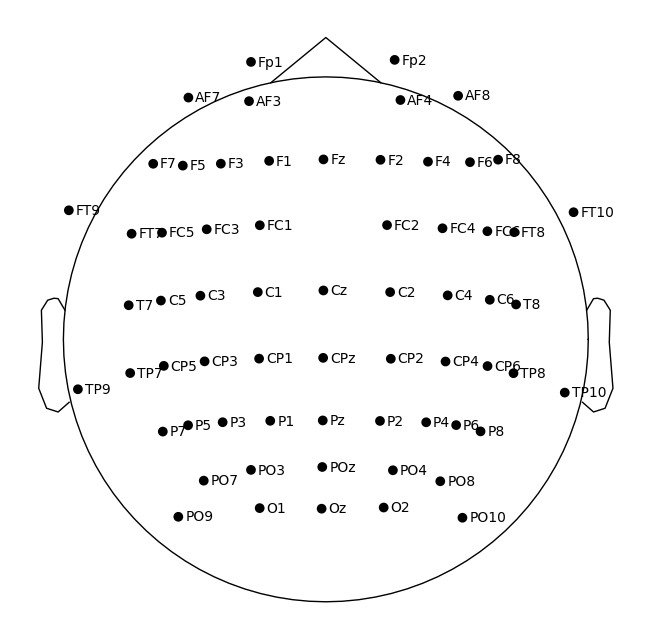

Cleaning channel names for ses-TestVisual...


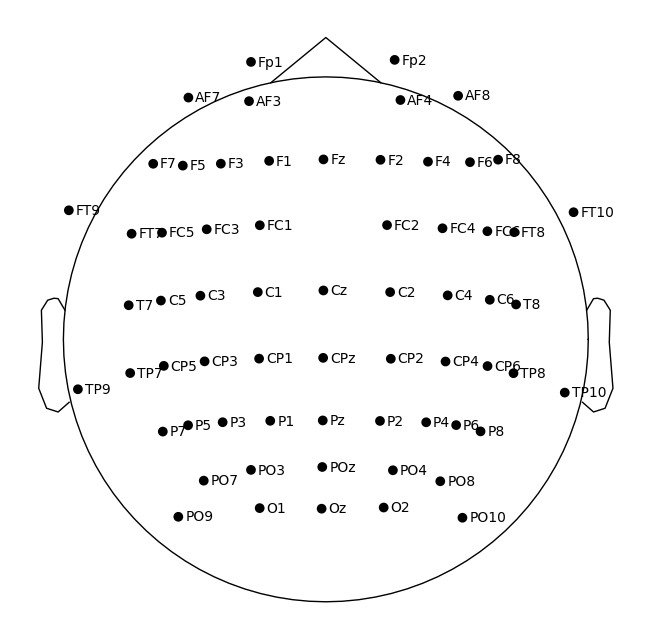

Cleaning channel names for ses-TestVibro...


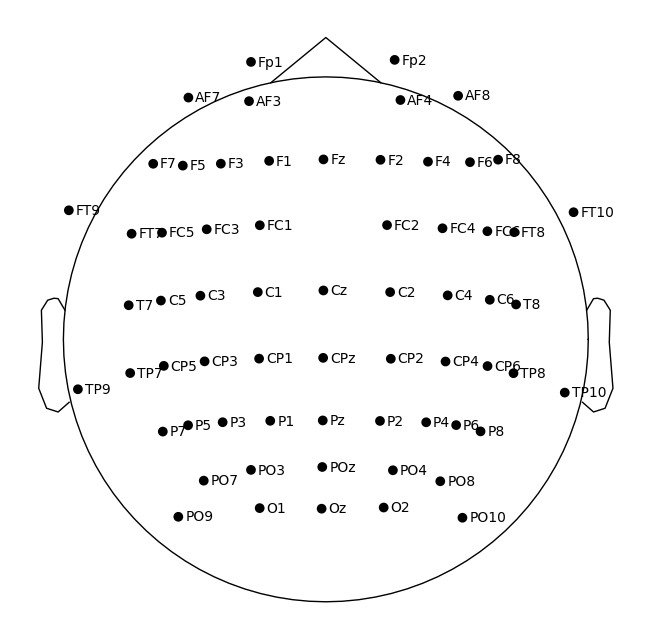

In [2]:
# We load the EEG Data for subject 1 for all sessions/conditions
raw_sessions = {}
for session, path in data_paths.items():
    print(f"Loading data for {session}...")
    vhdr_file = path / f"{subject}_{session}_task-PredError_eeg.vhdr"
    raw = mne.io.read_raw_brainvision(str(vhdr_file), preload=True)
    raw_sessions[session] = raw
    # print some metadata
    print(f"{session}: Channels={raw.info['nchan']}, Sampling rate={raw.info['sfreq']} Hz, Samples={raw.n_times}, Duration={raw.times[-1]:.2f} s")
    print(f"Original channels for {session}: {raw.info['ch_names']}")


# The channel names in the dataset have a prefix ("BrainVision RDA_") that is specific to the recording system
# We need to remove this prefix to match the standard EEG channel naming convention (e.g., "Fp1", "Fz")
for session, raw in raw_sessions.items():
    print(f"Cleaning channel names for {session}...")
    raw.rename_channels(lambda x: x.replace("BrainVision RDA_", ""))
    montage = mne.channels.make_standard_montage("standard_1020")
    raw.set_montage(montage)
    raw.plot_sensors(kind="topomap", show_names=True)

**Filter and downsample (Step 2)**  

We start the preporcessing --> filter and downsample the data. The paper says: “The raw EEG data was re-sampled to 250 Hz, high-pass filtered at 1 Hz, and low-pass filtered at 125 Hz.” However, filtering should happen before downsampling to avoid aliasing, so we’re doing it in that order instead. Their MATLAB does the same, so no difference here.

In [3]:
for session, raw in raw_sessions.items():
    # let's first check the frequency range of the data before bandpass
    psd, freqs = raw.compute_psd().get_data(return_freqs=True)
    max_freq = freqs.max()
    min_freq = freqs.min()
    print(f"Frequency range in the data: {min_freq} Hz to {max_freq} Hz")
    # Filter the Data (1–125 Hz bandpass)
    print(f"Filtering and downsampling for {session}...")
    raw.filter(l_freq=1, h_freq=124.9)  # Bandpass filter (1-125 Hz)
    raw.resample(250)  # Downsample to 250 Hz

Effective window size : 4.096 (s)
Frequency range in the data: 0.0 Hz to 249.996875039062 Hz
Filtering and downsampling for ses-TestEMS...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 1.2e+02 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 124.90 Hz
- Upper transition bandwidth: 31.23 Hz (-6 dB cutoff frequency: 140.51 Hz)
- Filter length: 1651 samples (3.302 s)



[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.1s


Effective window size : 4.096 (s)
Frequency range in the data: 0.0 Hz to 249.99662504556187 Hz
Filtering and downsampling for ses-TestVisual...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 1.2e+02 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 124.90 Hz
- Upper transition bandwidth: 31.23 Hz (-6 dB cutoff frequency: 140.51 Hz)
- Filter length: 1651 samples (3.302 s)



[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.2s


Effective window size : 4.096 (s)
Frequency range in the data: 0.0 Hz to 249.99675004224943 Hz
Filtering and downsampling for ses-TestVibro...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 1.2e+02 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 124.90 Hz
- Upper transition bandwidth: 31.23 Hz (-6 dB cutoff frequency: 140.51 Hz)
- Filter length: 1651 samples (3.302 s)



[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.2s


**Re-referencing (Step 3)**  
In the paper, they re-reference the data to the average of all electrodes, including FCz. We’ll follow that here too.

In [4]:
for session, raw in raw_sessions.items():
    print(f"Re-referencing data for {session}...")
    raw.set_eeg_reference("average")

Re-referencing data for ses-TestEMS...
EEG channel type selected for re-referencing
Applying average reference.
Applying a custom ('EEG',) reference.
Re-referencing data for ses-TestVisual...
EEG channel type selected for re-referencing
Applying average reference.
Applying a custom ('EEG',) reference.
Re-referencing data for ses-TestVibro...
EEG channel type selected for re-referencing
Applying average reference.
Applying a custom ('EEG',) reference.


In [ ]:
# **Epoch Rejection **
# The paper divides data into 1-second epochs and removes the noisiest 15%. This is skipped in our implementation to retain continuous data for ICA, simplifying the pipeline.
# The paper mentions rejecting 15% of the noisiest 1-second epochs before ICA to remove extreme artifacts. However, for simplicity, we skip this step.
# Skipping this step retains more data for analysis, but we acknowledge it might slightly reduce the quality of ICA results.


# for session, raw in raw_sessions.items():
#     print(f"Rejecting 15% of noisiest epochs for {session}...")
#     # Use autoreject or similar methods here if needed
#     pass

# %% [markdown]


**ICA analysis (step 4)**

Now we perform ICA analysis to remove artifacts like eye blinks and line noise.
The paper also does this but after their intial 1 second window epoching and noisy epochs removal. We think this might be because it helps the ICA result when the data is clean. But in our pipeline we directly do the ICA analysis on the raw continous data.

Running ICA for ses-TestEMS...
Fitting ICA to data using 64 channels (please be patient, this may take a while)
Selecting by number: 20 components
Fitting ICA took 4.9s.


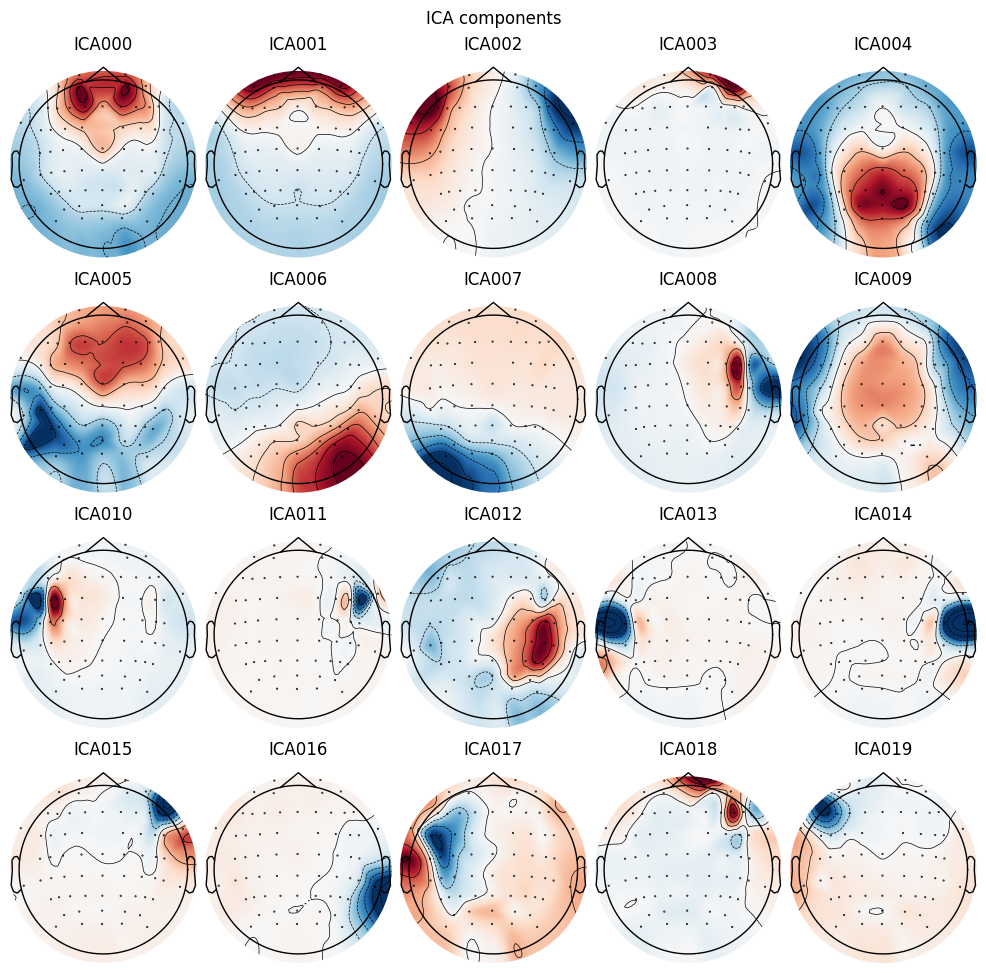

Applying ICA to Raw instance
    Transforming to ICA space (20 components)
    Zeroing out 0 ICA components
    Projecting back using 64 PCA components
Running ICA for ses-TestVisual...
Fitting ICA to data using 64 channels (please be patient, this may take a while)
Selecting by number: 20 components
Fitting ICA took 14.7s.


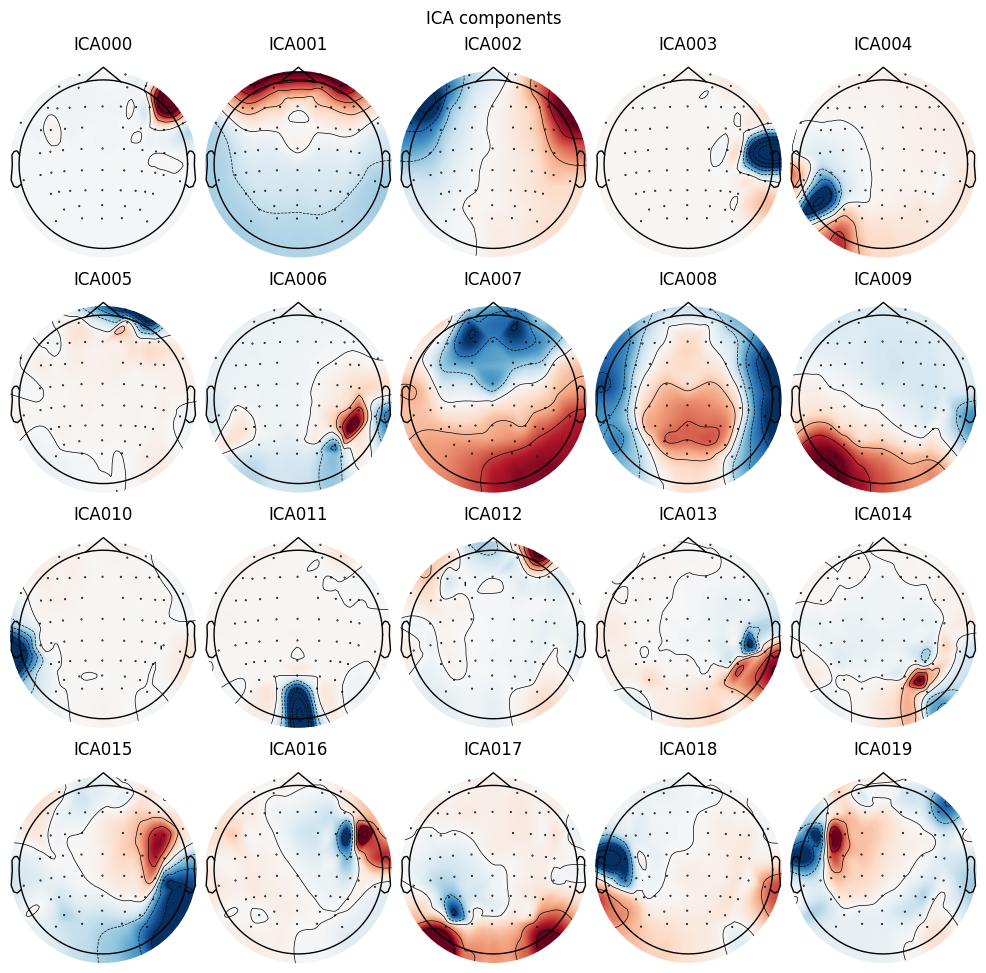

Applying ICA to Raw instance
    Transforming to ICA space (20 components)
    Zeroing out 0 ICA components
    Projecting back using 64 PCA components
Running ICA for ses-TestVibro...
Fitting ICA to data using 64 channels (please be patient, this may take a while)
Selecting by number: 20 components
Fitting ICA took 21.4s.


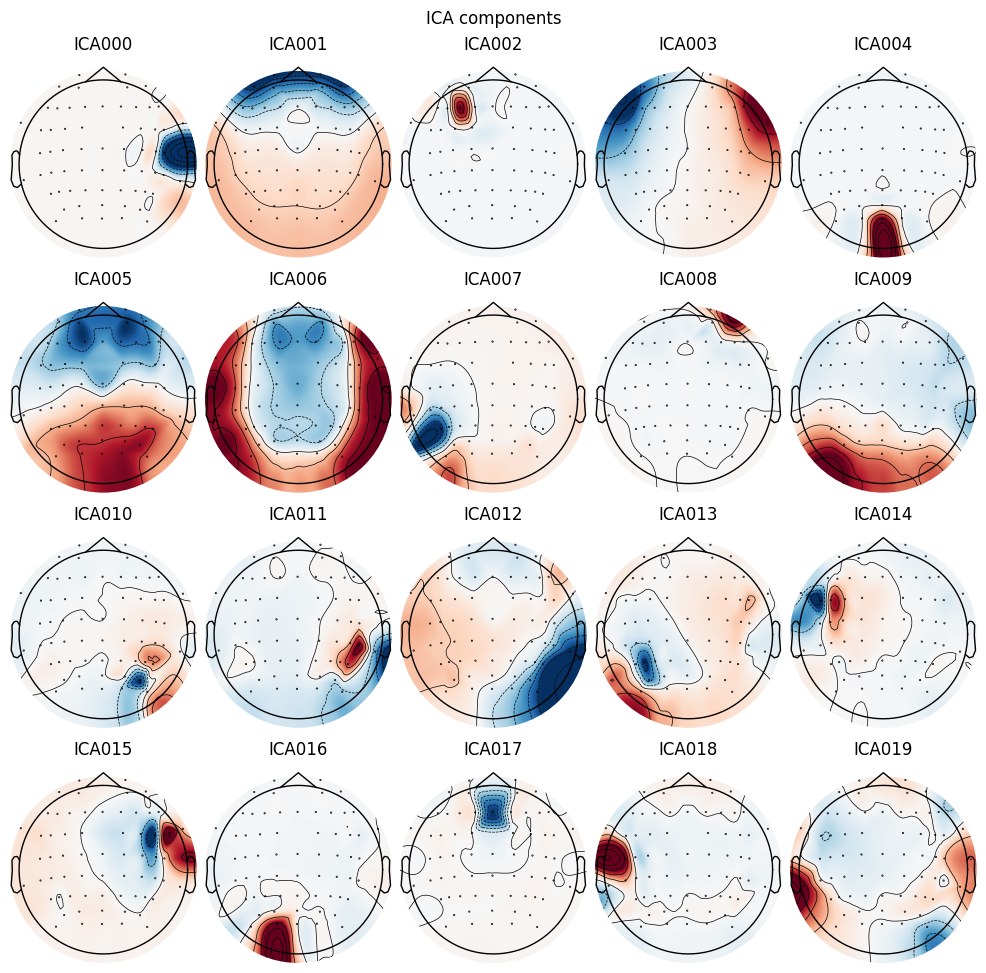

Applying ICA to Raw instance
    Transforming to ICA space (20 components)
    Zeroing out 0 ICA components
    Projecting back using 64 PCA components


In [ ]:

# %%
ica_sessions = {}
for session, raw in raw_sessions.items():
    print(f"Running ICA for {session}...")
    ica = mne.preprocessing.ICA(n_components=20, random_state=42, max_iter="auto")
    ica.fit(raw)
    ica.plot_components()  # Inspect components manually

    # TO DO: we need to identify the bad components by visually inspecting, not sure how to interpret the plots
    ica.exclude = []  # Adjust based on visual inspection
    ica.apply(raw)
    ica_sessions[session] = raw

**ERP-Specific Filtering (Step 5)**

To isolate ERP-related frequencies, the paper specifies filtering the data at 0.2–35 Hz. This helps focus on the relevant signals
and is applied to the ICA-cleaned data.

In [7]:
for session, raw in ica_sessions.items():
    print(f"Filtering for ERP analysis in {session}...")
    raw.filter(l_freq=0.2, h_freq=35)

Filtering for ERP analysis in ses-TestEMS...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.2 - 35 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.20
- Lower transition bandwidth: 0.20 Hz (-6 dB cutoff frequency: 0.10 Hz)
- Upper passband edge: 35.00 Hz
- Upper transition bandwidth: 8.75 Hz (-6 dB cutoff frequency: 39.38 Hz)
- Filter length: 4125 samples (16.500 s)

Filtering for ERP analysis in ses-TestVisual...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.2 - 35 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.2

[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.1s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.2s


Filtering for ERP analysis in ses-TestVibro...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.2 - 35 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.20
- Lower transition bandwidth: 0.20 Hz (-6 dB cutoff frequency: 0.10 Hz)
- Upper passband edge: 35.00 Hz
- Upper transition bandwidth: 8.75 Hz (-6 dB cutoff frequency: 39.38 Hz)
- Filter length: 4125 samples (16.500 s)



[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.1s


**Epoching around stimulus (step 6)**

We create epochs aligned to the stimulus event `box:touched` which is the moment of object selection. In the paper they state "Then we sliced it between -0.3 seconds to 0.7 seconds around the stimulus onset, i.e. the moment of object selection". We think the `box:touched` probably correponds to the "moment of object selection" so thats what we are using to align out epochs. 

In [ ]:
epochs_sessions = {}
tmin, tmax = -0.3, 0.7
event_id = {"box:touched": 2}

for session, raw in ica_sessions.items():
    print(f"Creating stimulus-aligned epochs for {session}...")
    # Extract events
    events_file = data_paths[session] / f"{subject}_{session}_task-PredError_events.tsv"
    events_df = pd.read_csv(events_file, sep="\t")

    # Map events
    events = []
    for _, row in events_df.iterrows():
        if row["value"] in event_id:
            sample = int(row["sample"])
            events.append([sample, 0, event_id[row["value"]]])
    events = np.array(events)

    # Epoching, drop duplicate event too
    epochs = mne.Epochs(
        raw, events, event_id=event_id, tmin=tmin, tmax=tmax,
        baseline=(None, 0), preload=True, event_repeated="drop"
    )
    epochs_sessions[session] = epochs
    print(f"Extracted {len(epochs)} epochs for {session}.")



Creating stimulus-aligned epochs for ses-TestEMS...
Multiple event values for single event times found. Keeping the first occurrence and dropping all others.
Not setting metadata
101 matching events found
Setting baseline interval to [-0.3, 0.0] s
Applying baseline correction (mode: mean)
0 projection items activated
Using data from preloaded Raw for 101 events and 251 original time points ...
47 bad epochs dropped
Extracted 54 epochs for ses-TestEMS.
Creating stimulus-aligned epochs for ses-TestVisual...
Multiple event values for single event times found. Keeping the first occurrence and dropping all others.
Not setting metadata
300 matching events found
Setting baseline interval to [-0.3, 0.0] s
Applying baseline correction (mode: mean)
0 projection items activated
Using data from preloaded Raw for 300 events and 251 original time points ...
123 bad epochs dropped
Extracted 177 epochs for ses-TestVisual.
Creating stimulus-aligned epochs for ses-TestVibro...
Multiple event values for 

**Epoch Rejection (Step 7)**

Following the paper, we reject the 10% noisiest epochs. 

In [9]:
for session, epochs in epochs_sessions.items():
    print(f"Rejecting 10% of noisiest epochs for {session}...")
    reject_criteria = dict(eeg=200e-6)  # need to find a good threshold
    epochs.drop_bad(reject=reject_criteria)

Rejecting 10% of noisiest epochs for ses-TestEMS...
    Rejecting  epoch based on EEG : ['Fp1']
    Rejecting  epoch based on EEG : ['FC5', 'FT7', 'C5']
    Rejecting  epoch based on EEG : ['Fp2', 'AF8']
3 bad epochs dropped
Rejecting 10% of noisiest epochs for ses-TestVisual...
    Rejecting  epoch based on EEG : ['AF8']
    Rejecting  epoch based on EEG : ['AF7']
    Rejecting  epoch based on EEG : ['Fp2', 'AF8']
    Rejecting  epoch based on EEG : ['F8']
    Rejecting  epoch based on EEG : ['AF8']
    Rejecting  epoch based on EEG : ['Fp1', 'Fp2', 'AF7', 'AF8']
    Rejecting  epoch based on EEG : ['Fp1', 'AF7', 'AF8']
    Rejecting  epoch based on EEG : ['Fp1', 'Fp2', 'F7', 'AF7']
    Rejecting  epoch based on EEG : ['Fp2', 'AF8']
    Rejecting  epoch based on EEG : ['TP9']
    Rejecting  epoch based on EEG : ['Fp1', 'Fp2', 'F7', 'F3', 'F4', 'F8', 'AF7', 'AF3', 'AF8', 'F6']
    Rejecting  epoch based on EEG : ['P7']
    Rejecting  epoch based on EEG : ['TP9', 'P7', 'P8', 'PO9', 'TP7

**ERP Analysis (step 8)**

In this step, we calculate and visualize the ERP by averaging the epochs. However, unlike the paper, we are not separating the epochs into matching and non-matching trials because the dataset does not include specific markers for this. A possible workaround could involve analyzing the order of events (e.g., box:touched, visual:off, etc.), but this would require additional assumptions.

Also, the paper mentions focusing on the FCz channel for ERP analysis, but this channel is not present in the dataset for participant 1. Therefore, we use the Fz channel as an alternative for the analysis.

Computing ERPs for ses-TestEMS...
Channels available in ses-TestEMS: ['Fp1', 'Fp2', 'F7', 'F3', 'Fz', 'F4', 'F8', 'FC5', 'FC1', 'FC2', 'FC6', 'T7', 'C3', 'Cz', 'C4', 'T8', 'TP9', 'CP5', 'CP1', 'CP2', 'CP6', 'TP10', 'P7', 'P3', 'Pz', 'P4', 'P8', 'PO9', 'O1', 'Oz', 'O2', 'PO10', 'AF7', 'AF3', 'AF4', 'AF8', 'F5', 'F1', 'F2', 'F6', 'FT9', 'FT7', 'FC3', 'FC4', 'FT8', 'FT10', 'C5', 'C1', 'C2', 'C6', 'TP7', 'CP3', 'CPz', 'CP4', 'TP8', 'P5', 'P1', 'P2', 'P6', 'PO7', 'PO3', 'POz', 'PO4', 'PO8']
Using Fz for ERP computation in ses-TestEMS.
Need more than one channel to make topography for eeg. Disabling interactivity.


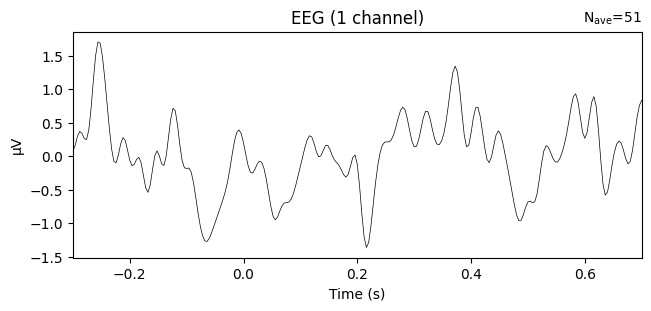

Computing ERPs for ses-TestVisual...
Channels available in ses-TestVisual: ['Fp1', 'Fp2', 'F7', 'F3', 'Fz', 'F4', 'F8', 'FC5', 'FC1', 'FC2', 'FC6', 'T7', 'C3', 'Cz', 'C4', 'T8', 'TP9', 'CP5', 'CP1', 'CP2', 'CP6', 'TP10', 'P7', 'P3', 'Pz', 'P4', 'P8', 'PO9', 'O1', 'Oz', 'O2', 'PO10', 'AF7', 'AF3', 'AF4', 'AF8', 'F5', 'F1', 'F2', 'F6', 'FT9', 'FT7', 'FC3', 'FC4', 'FT8', 'FT10', 'C5', 'C1', 'C2', 'C6', 'TP7', 'CP3', 'CPz', 'CP4', 'TP8', 'P5', 'P1', 'P2', 'P6', 'PO7', 'PO3', 'POz', 'PO4', 'PO8']
Using Fz for ERP computation in ses-TestVisual.
Need more than one channel to make topography for eeg. Disabling interactivity.


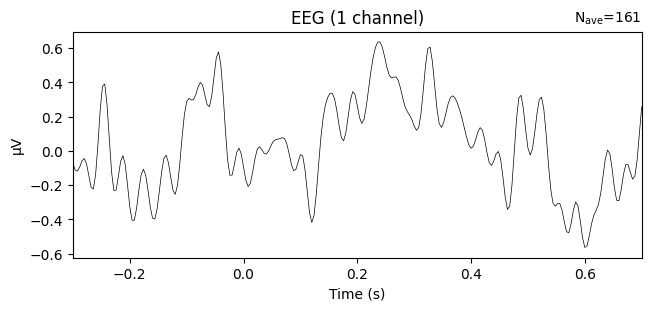

Computing ERPs for ses-TestVibro...
Channels available in ses-TestVibro: ['Fp1', 'Fp2', 'F7', 'F3', 'Fz', 'F4', 'F8', 'FC5', 'FC1', 'FC2', 'FC6', 'T7', 'C3', 'Cz', 'C4', 'T8', 'TP9', 'CP5', 'CP1', 'CP2', 'CP6', 'TP10', 'P7', 'P3', 'Pz', 'P4', 'P8', 'PO9', 'O1', 'Oz', 'O2', 'PO10', 'AF7', 'AF3', 'AF4', 'AF8', 'F5', 'F1', 'F2', 'F6', 'FT9', 'FT7', 'FC3', 'FC4', 'FT8', 'FT10', 'C5', 'C1', 'C2', 'C6', 'TP7', 'CP3', 'CPz', 'CP4', 'TP8', 'P5', 'P1', 'P2', 'P6', 'PO7', 'PO3', 'POz', 'PO4', 'PO8']
Using Fz for ERP computation in ses-TestVibro.
Need more than one channel to make topography for eeg. Disabling interactivity.


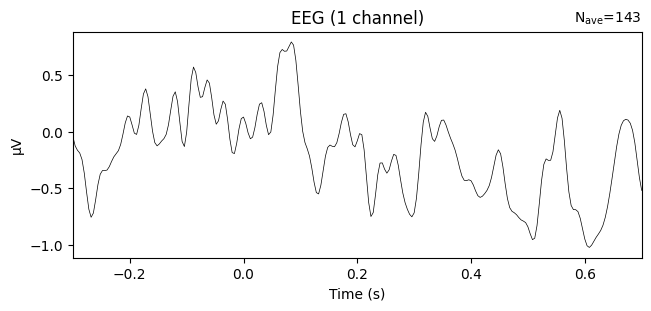

In [10]:

for session, epochs in epochs_sessions.items():
    print(f"Computing ERPs for {session}...")

    # Debugging Step: Check channel names
    print(f"Channels available in {session}: {epochs.info['ch_names']}")

    # Use FCz if available, otherwise default to Fz
    channel_to_use = "FCz" if "FCz" in epochs.info["ch_names"] else "Fz"

    if channel_to_use not in epochs.info["ch_names"]:
        print(f"Warning: Neither FCz nor Fz found in {session}. Skipping this session.")
        continue  # Skip the session if neither FCz nor Fz is available

    print(f"Using {channel_to_use} for ERP computation in {session}.")
    evoked = epochs["box:touched"].average(picks=channel_to_use)

    # Plot the ERP
    fig = evoked.plot()
    fig.suptitle(f"ERP for box:touched ({channel_to_use}) in {session}")  # Add a descriptive title